In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from ens_util import *
from math import isnan
from sklearn.calibration import calibration_curve
plt.rcParams['figure.figsize'] = [9,9]

In [3]:
data_files = glob('data_crop*.nc')
#res_files = glob('2014*Z_crs_gauss.nc')
coordx = [258]
coordy = [63]
thresh = 0.2
data = build_datadf(data_files,coordx,coordy)
(fr15,fr30,fr45,fr60) = build_benchmark_fractions(data_files,data.index,thresh)
fr = [fr15,fr30,fr45,fr60]

data_crop_04_02.nc
data_crop_04_05.nc
data_crop_04_09.nc
data_crop_04_10.nc
data_crop_04_11.nc
data_crop_04_12.nc
data_crop_04_15.nc
data_crop_04_18.nc
data_crop_04_19.nc
data_crop_04_20.nc
data_crop_04_21.nc
data_crop_04_22.nc
data_crop_04_25.nc
data_crop_04_26.nc
data_crop_05_05.nc
data_crop_05_06.nc
data_crop_05_07.nc
data_crop_05_08.nc
data_crop_05_09.nc
data_crop_05_19.nc
data_crop_05_20.nc
data_crop_05_21.nc
data_crop_05_22.nc
data_crop_05_23.nc
data_crop_05_24.nc
data_crop_05_25.nc
data_crop_05_29.nc
data_crop_05_30.nc
data_crop_06_03.nc
data_crop_06_10.nc
data_crop_06_11.nc
data_crop_06_12.nc
data_crop_06_14.nc
data_crop_06_15.nc
data_crop_06_16.nc
data_crop_06_17.nc
data_crop_06_18.nc
data_crop_06_19.nc
data_crop_06_22.nc


In [4]:
index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index
bs15 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs30 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs45 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs60 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs = [bs15,bs30,bs45,bs60]

In [5]:
#Better way to do the brier score calculations

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

for c in data.columns:
    for d in index_dates_unique:
        times = index_times[np.where(index_dates==d)]
        sat = data_bin.loc[times,[c]]
        for f in range(4):
            frac = fr[f].loc[times,[c]]
            bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
            valid = np.where(np.invert(np.isnan(bs_vals)))
            bs[f].at[d,c] = np.sum(bs_vals[valid])/len(bs_vals[valid])

In [6]:
#Brier Score decomposition
c=0
f=0
d=index_dates_unique[0]
times = index_times[np.where(index_dates==d)]
sat = data_bin.loc[times,[c]]
frac = fr[f].loc[times,[c]]

bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
sat_vals = sat.values[:,0].astype(np.float)
frac_vals = frac.values[:,0].astype(np.float)

valid = np.where(np.invert(np.isnan(bs_vals)))
bs_valid = bs_vals[valid]
sat_valid = sat_vals[valid]
frac_valid = frac_vals[valid]
print(bs_valid,sat_valid,frac_valid)

[1.79368622e-06 7.97193878e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.76562500e-06 8.68144133e-04
 2.84765625e-02 4.96255182e-02 2.46938776e-02 4.48421556e-03
 1.79368622e-02 1.49625319e-02 1.56250000e-04 1.56250000e-04
 1.34725765e-04 2.87786990e-04] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.99866071 0.99910714 1.         1.         1.         1.
 0.996875   0.97053571 0.83125    0.77723214 0.84285714 0.93303571
 0.86607143 0.87767857 0.9875     0.9875     0.98839286 0.98303571]


In [7]:
# Follows Wilks Ch. 8
unique,counts = np.unique(frac_valid,return_counts=True) #counts are N_i values
n = np.sum(counts) # n

obar_i = np.zeros(len(unique))
for j in range(len(unique)):
    y = unique[j]
    wh = np.where(frac_valid==y)
    obar_i[j] = np.sum(sat_valid[wh])/counts[j]

obar = np.sum(sat_valid)/n

sig = obar*(1-obar)
rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n

print(rel,res,sig,rel-res+sig)

0.007877504517431973 0.0 0.0 0.007877504517431973


In [13]:
# would have to create new columns for each coordinate location
dec15 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec30 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec45 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec60 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs','bss'])
dec = [dec15,dec30,dec45,dec60]

c=0
for d in index_dates_unique:
    times = index_times[np.where(index_dates==d)]
    sat = data_bin.loc[times,[c]]
    for f in range(4):
        frac = fr[f].loc[times,[c]]
        bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
        sat_vals = sat.values[:,0].astype(np.float)
        frac_vals = frac.values[:,0].astype(np.float)
        valid = np.where(np.invert(np.isnan(bs_vals)))
        bs_valid = bs_vals[valid]
        sat_valid = sat_vals[valid]
        frac_valid = frac_vals[valid]
        
        unique,counts = np.unique(frac_valid,return_counts=True)
        n = np.sum(counts)
        obar_i = np.zeros(len(unique))
        for j in range(len(unique)):
            y = unique[j]
            wh = np.where(frac_valid==y)
            obar_i[j] = np.sum(sat_valid[wh])/counts[j]
        obar = np.sum(sat_valid)/n

        sig = obar*(1-obar)
        rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
        res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n
        dec[f].at[d,'rel'] = rel
        dec[f].at[d,'res'] = res
        dec[f].at[d,'sig'] = sig
        dec[f].at[d,'bs'] = rel-res+sig
print(dec30)

                    rel        res        sig           bs  bss
2014-04-02    0.0087055          0          0    0.0087055  NaN
2014-04-05     0.115607    0.17284    0.17284     0.115607  NaN
2014-04-09    0.0501104  0.0524691  0.0524691    0.0501104  NaN
2014-04-10  0.000331819          0          0  0.000331819  NaN
2014-04-11     0.218464    0.17284    0.17284     0.218464  NaN
2014-04-12     0.163832    0.17284    0.17284     0.163832  NaN
2014-04-15     0.093972  0.0987654  0.0987654     0.093972  NaN
2014-04-18            0          0          0            0  NaN
2014-04-19     0.152598       0.25       0.25     0.152598  NaN
2014-04-20   0.00694618          0          0   0.00694618  NaN
2014-04-21  2.00295e-05          0          0  2.00295e-05  NaN
2014-04-22  0.000159107          0          0  0.000159107  NaN
2014-04-25   1.5501e-07          0          0   1.5501e-07  NaN
2014-04-26     0.158738  0.0987654  0.0987654     0.158738  NaN
2014-05-05  5.53607e-08          0      

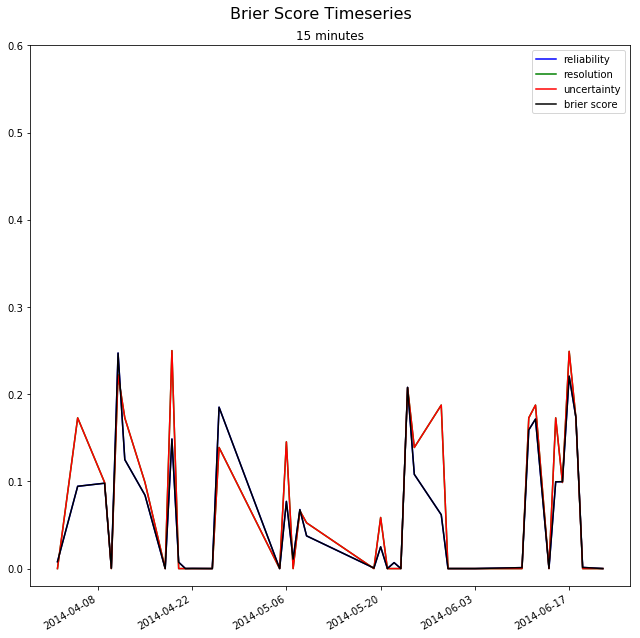

In [9]:
ymin= -0.02
ymax = 0.6
rows = 1; cols = 1;
fig,ax = plt.subplots(rows,cols)
ax.set_ylim([ymin,ymax])

ax.plot(dec15.index,dec15.values[:,0],c='b',label='reliability')
ax.plot(dec15.index,dec15.values[:,1],c='g',label='resolution')
ax.plot(dec15.index,dec15.values[:,2],c='r',label='uncertainty')
ax.plot(dec15.index,dec15.values[:,3],c='k',label='brier score')

ax.set_title("15 minutes")

fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.legend()
plt.show()

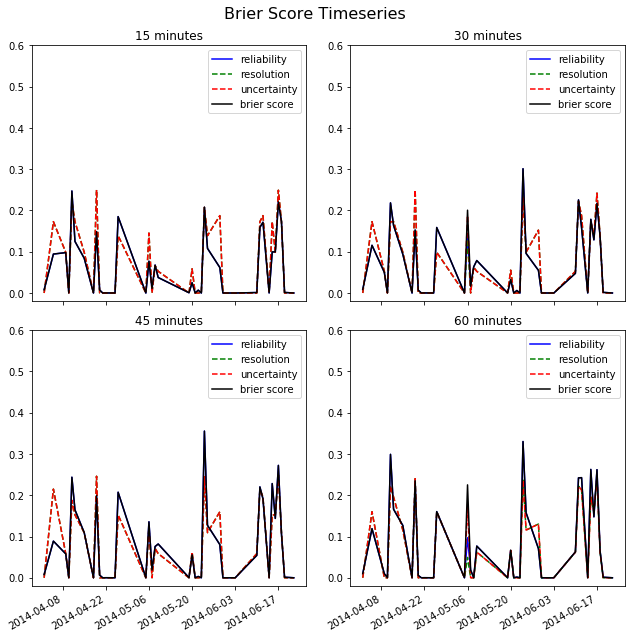

In [10]:
coord = 0
ymin= -0.02
ymax = 0.6
rows = 2; cols = 2;
fig,axarr = plt.subplots(rows,cols)
for r in range(rows):
    for c in range(cols):
        axarr[r,c].set_ylim([ymin,ymax])
        

        
axarr[0,0].plot(dec15.index,dec15.values[:,0],c='b',label='reliability')
axarr[0,0].plot(dec15.index,dec15.values[:,1],c='g',ls='--',label='resolution')
axarr[0,0].plot(dec15.index,dec15.values[:,2],c='r',ls='--',label='uncertainty')
axarr[0,0].plot(dec15.index,dec15.values[:,3],c='k',label='brier score')

axarr[0,1].plot(dec15.index,dec30.values[:,0],c='b',label='reliability')
axarr[0,1].plot(dec15.index,dec30.values[:,1],c='g',ls='--',label='resolution')
axarr[0,1].plot(dec15.index,dec30.values[:,2],c='r',ls='--',label='uncertainty')
axarr[0,1].plot(dec15.index,dec30.values[:,3],c='k',label='brier score')

axarr[1,0].plot(dec15.index,dec45.values[:,0],c='b',label='reliability')
axarr[1,0].plot(dec15.index,dec45.values[:,1],c='g',ls='--',label='resolution')
axarr[1,0].plot(dec15.index,dec45.values[:,2],c='r',ls='--',label='uncertainty')
axarr[1,0].plot(dec15.index,dec45.values[:,3],c='k',label='brier score')

axarr[1,1].plot(dec15.index,dec60.values[:,0],c='b',label='reliability')
axarr[1,1].plot(dec15.index,dec60.values[:,1],c='g',ls='--',label='resolution')
axarr[1,1].plot(dec15.index,dec60.values[:,2],c='r',ls='--',label='uncertainty')
axarr[1,1].plot(dec15.index,dec60.values[:,3],c='k',label='brier score')

axarr[0,0].set_title("15 minutes")
axarr[0,1].set_title("30 minutes")
axarr[1,0].set_title("45 minutes")
axarr[1,1].set_title("60 minutes")

axarr[0,0].legend()
axarr[0,1].legend()
axarr[1,0].legend()
axarr[1,1].legend()

fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()